<a href="https://colab.research.google.com/github/agarwalarpit99/Deep-Learning-projects/blob/master/Chest_xray_using_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arpitkumaragarwal","key":"f53e388348af4c75f8d2d0e42bac13cf"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 94.9MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.8MB/s]


In [5]:
from zipfile import ZipFile
file_name='chest-xray-pneumonia.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob 

In [0]:
path_train='/content/chest_xray/chest_xray/train'
path_test='/content/chest_xray/chest_xray/test'
path_val='/content/chest_xray/chest_xray/val'

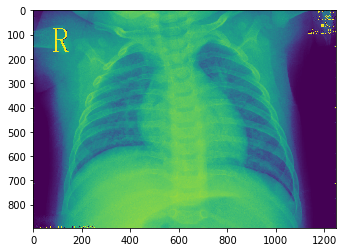

In [0]:
img=glob(path_train+"/PNEUMONIA/*.jpeg") #Getting all pnenmonia images in this folder
img1=np.asarray(plt.imread(img[0]))
plt.imshow(img1)

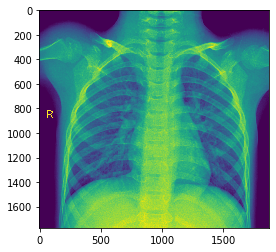

In [0]:
img2=glob(path_train+'/NORMAL/*.jpeg')
img2_arr=np.asarray(plt.imread(img2[0]))
plt.imshow(img2_arr)

In [0]:
img2_arr.shape

(1774, 1874)

In [8]:
#Tranfer learning
from keras.layers import Dense,Flatten,Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.preprocessing import image

Using TensorFlow backend.


In [9]:
#input size because vgg16 is train on (224,224) image sizes
#weight are fixed
#include top means not include the last layer
image_size=[224,224]
vgg=VGG16(input_shape=image_size+[3],weights='imagenet',include_top=False)





58892288/58889256 [==============================] - 1s 0us/step








In [0]:
#for not training of vgg layers
for layer in vgg.layers:
  layer.trainable=False

In [0]:
classes=glob('/content/chest_xray/chest_xray/train/*')

In [0]:
#For flattenting the output of vgg convonutional layers
x=Flatten()(vgg.output)

In [0]:
#len(classes) means no. of classes
#(x) means the o/p from the convoltional layer
prediction_layer=Dense(len(classes),activation='softmax')(x)

In [14]:
model=Model(input=vgg.input,output=prediction_layer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [0]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [15]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
train_gen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip=True)
val_gen=ImageDataGenerator(rescale=1./255)

In [17]:
#For creating batches(directiory) of train,test and val data and converting images to the equal sizes

train_batches = train_gen.flow_from_directory(path_train, target_size = (224, 224),
                                              batch_size=32,
                 class_mode = "categorical")
val_batches = val_gen.flow_from_directory(path_val, target_size = (224, 224), 
                 class_mode = "categorical")
test_batches = val_gen.flow_from_directory(path_test, target_size = (224, 224), 
                                           batch_size=32,
                     class_mode = "categorical")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [18]:
r = model.fit_generator(
  train_batches,
  validation_data=test_batches,
  epochs=5,
  steps_per_epoch=len(train_batches),
  validation_steps=len(test_batches)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
163/163 [==============================] - 111s 682ms/step - loss: 0.1713 - acc: 0.9296 - val_loss: 0.2216 - val_acc: 0.9183
Epoch 2/5
163/163 [==============================] - 110s 675ms/step - loss: 0.1001 - acc: 0.9626 - val_loss: 0.4586 - val_acc: 0.8750
Epoch 3/5
163/163 [==============================] - 111s 680ms/step - loss: 0.1019 - acc: 0.9636 - val_loss: 0.2878 - val_acc: 0.9151
Epoch 4/5
163/163 [==============================] - 103s 635ms/step - loss: 0.0903 - acc: 0.9663 - val_loss: 0.3562 - val_acc: 0.9103
Epoch 5/5
163/163 [==============================] - 102s 629ms/step - loss: 0.0900 - acc: 0.9672 - val_loss: 0.3016 - val_acc: 0.9087


In [19]:
p = model.predict_generator(test_batches, verbose=True)
pre = pd.DataFrame(p)
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)

20/20 [==============================] - 6s 303ms/step


In [21]:
test_batches.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [20]:
pre.head(20)

,0,1,filename,label,pre
0,0.023555,9.764454e-01,NORMAL/IM-0001-0001.jpeg,0,1
1,0.057113,9.428867e-01,NORMAL/IM-0003-0001.jpeg,0,1
2,0.004078,9.959220e-01,NORMAL/IM-0005-0001.jpeg,0,1
3,0.999896,1.044342e-04,NORMAL/IM-0006-0001.jpeg,0,0
4,0.850561,1.494392e-01,NORMAL/IM-0007-0001.jpeg,0,0
5,0.999972,2.802930e-05,NORMAL/IM-0009-0001.jpeg,0,0
6,0.010585,9.894153e-01,NORMAL/IM-0010-0001.jpeg,0,1
7,0.049343,9.506568e-01,NORMAL/IM-0011-0001-0001.jpeg,0,1
8,0.876559,1.234406e-01,NORMAL/IM-0011-0001-0002.jpeg,0,0
9,0.000908,9.990921e-01,NORMAL/IM-0011-0001.jpeg,0,1


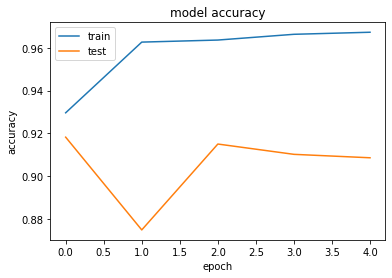

In [22]:
plt.plot(r.history['acc'])
plt.plot(r.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

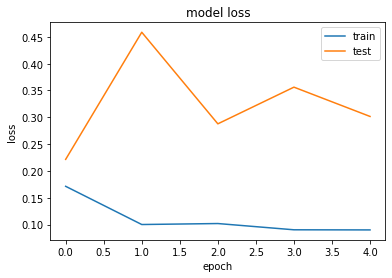

In [23]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [0]:
model.save('model_vgg16.h5')

In [0]:
from keras.models import load_model
model_load=load_model('model_vgg16.h5')

In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
img=image.load_img('/content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg',target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
class1=model_load.predict(img_data)

In [31]:
class1 #which indicate normal

array([[0., 1.]], dtype=float32)

In [0]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
optimizer = Adam(lr = 0.0001)
early_stopping_monitor = EarlyStopping(patience = 3, monitor = "val_acc", mode="max", verbose = 2)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
history = model.fit_generator(epochs=5, callbacks=[early_stopping_monitor], shuffle=True,
                              validation_data=val_batches, generator=train_batches, 
                              steps_per_epoch=500, validation_steps=10,verbose=2)
#prediction = model.predict_generator(generator=train_batches, verbose=2, steps=100)

Epoch 1/5
 - 296s - loss: 4.1403 - acc: 0.7431 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 292s - loss: 4.1474 - acc: 0.7427 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
 - 295s - loss: 4.1695 - acc: 0.7413 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
 - 292s - loss: 4.1051 - acc: 0.7453 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 00004: early stopping
